In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,  auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Load the dataset
data = pd.read_csv("income.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Handling missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

for col in data.select_dtypes(include=['number']).columns:
    data[col] = num_imputer.fit_transform(data[[col]]).ravel()

for col in data.select_dtypes(include=['object']).columns:
    data[col] = cat_imputer.fit_transform(data[[col]]).ravel()

In [4]:
# Convert income to binary
data['income'] = data['income'].replace({'<=50K': 0, '<=50K.' : 0, '>50K': 1,  '>50K.':1})


<ipython-input-4-93a31c28c541>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['income'] = data['income'].replace({'<=50K': 0, '<=50K.' : 0, '>50K': 1,  '>50K.':1})


In [5]:
# Encode categorical features
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col].astype(str))

In [6]:
# Splitting into features and target
X = data.drop(columns=['income'])
y = data['income']

In [7]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Deeplearning Menggunakan PyTorch

In [19]:
# Build a simple neural network model
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [20]:
# Initialize the model
input_dim = X_train.shape[1]
model = PyTorchModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Convert the data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [24]:
# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [25]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)


In [26]:
# Metrics evaluation for PyTorch
accuracy_pytorch = accuracy_score(y_test, y_pred)
precision_pytorch = precision_score(y_test, y_pred)
recall_pytorch = recall_score(y_test, y_pred)
f1_pytorch = f1_score(y_test, y_pred)
auc_pytorch = roc_auc_score(y_test, y_pred_prob)

In [27]:
# Print metrics for PyTorch
print(f'PyTorch Accuracy: {accuracy_pytorch:.4f}')
print(f'PyTorch Precision: {precision_pytorch:.4f}')
print(f'PyTorch Recall: {recall_pytorch:.4f}')
print(f'PyTorch F1 Score: {f1_pytorch:.4f}')
print(f'PyTorch AUC: {auc_pytorch:.4f}')

PyTorch Accuracy: 0.7896
PyTorch Precision: 0.5452
PyTorch Recall: 0.7677
PyTorch F1 Score: 0.6376
PyTorch AUC: 0.8713


In [29]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()

In [30]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

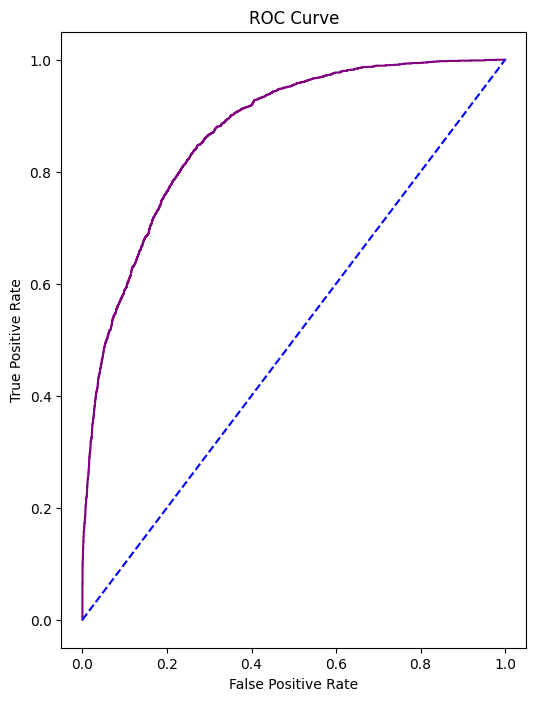

In [49]:
# Plot ROC curve
plt.figure(figsize=(6, 8))
plt.plot(fpr, tpr, color='purple')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Model Deeplearning Menggunakan TensorFlow

In [35]:
# Build a neural network model using TensorFlow
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
# Initialize the model
model = build_model(X_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8201 - loss: 0.3924
Epoch 2/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8557 - loss: 0.3230
Epoch 3/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8635 - loss: 0.3057
Epoch 4/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8633 - loss: 0.2994
Epoch 5/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8680 - loss: 0.2927
Epoch 6/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8699 - loss: 0.2868
Epoch 7/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8721 - loss: 0.2811
Epoch 8/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8751 - loss: 0.2745
Epoch 9/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8787 - loss: 0.2703
Epoch 10/10
1859/1859 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8780 - loss: 0.2660


In [40]:
# Evaluate the model
y_pred_prob_tf = model.predict(X_test)
y_pred_tf = (y_pred_prob_tf >= 0.5).astype(int)

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [41]:
# Metrics evaluation for TensorFlow
accuracy_tf = accuracy_score(y_test, y_pred_tf)
precision_tf = precision_score(y_test, y_pred_tf)
recall_tf = recall_score(y_test, y_pred_tf)
f1_tf = f1_score(y_test, y_pred_tf)
auc_value = roc_auc_score(y_test, y_pred_prob)

In [42]:
# Print metrics for TensorFlow
print(f'TensorFlow Accuracy: {accuracy_tf:.4f}')
print(f'TensorFlow Precision: {precision_tf:.4f}')
print(f'TensorFlow Recall: {recall_tf:.4f}')
print(f'TensorFlow F1 Score: {f1_tf:.4f}')
print(f'TensorFlow AUC: {auc_value:.4f}')

TensorFlow Accuracy: 0.8343
TensorFlow Precision: 0.6414
TensorFlow Recall: 0.7087
TensorFlow F1 Score: 0.6734
TensorFlow AUC: 0.8713


In [44]:
# Compute ROC curve and AUC for visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc

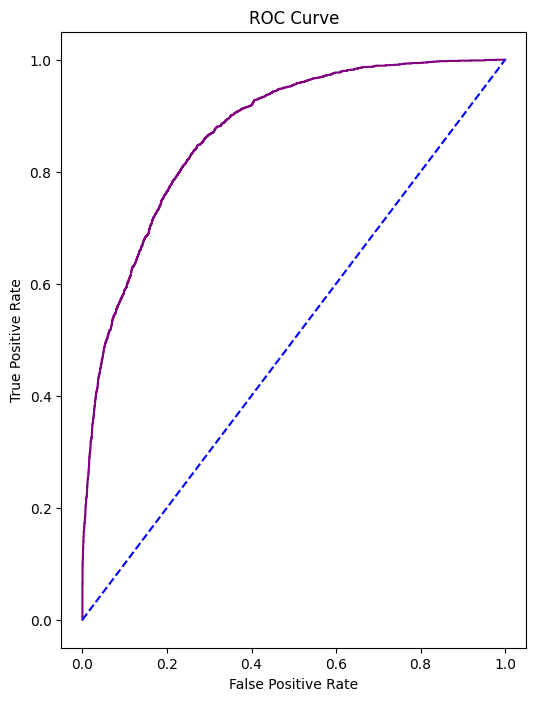

In [50]:
# Plot ROC curve
plt.figure(figsize=(6, 8))
plt.plot(fpr, tpr, color='purple')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

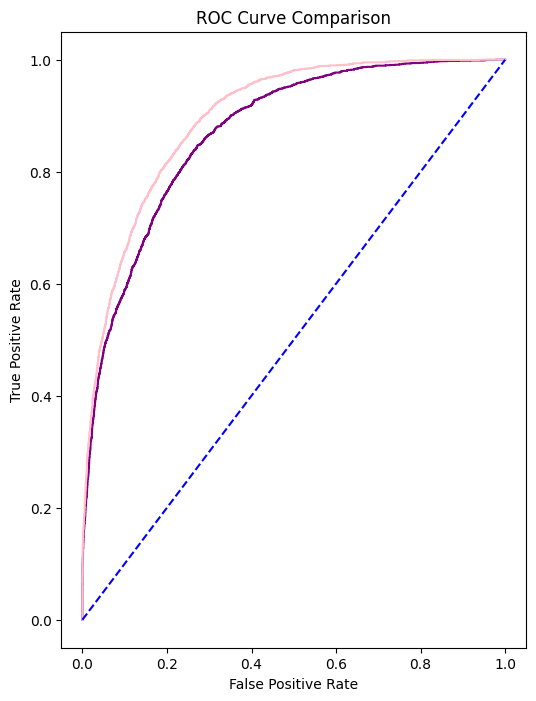

In [51]:
# Plot ROC curve for both models
fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, y_pred_prob)
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_prob_tf)
plt.figure(figsize=(6, 8))
plt.plot(fpr_pytorch, tpr_pytorch, color='purple')
plt.plot(fpr_tf, tpr_tf, color='pink')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.show()

## Perbandingan antara Model PyTorch dan TensorFlow

### 1. **Akurasi**
Model TensorFlow lebih akurat. Artinya model TensorFlow memprediksi lebih benar dibandingkan model PyTorch.

### 2. **Presisi**
TensorFlow lebih unggul unggul dalam hal presisi. Artinya dari semua prediksi yang dianggap positif oleh model TensorFlow lebih banyak yang benar-benar positif.

### 3. **Recall**
PyTorch sedikit lebih baik dalam hal recall. Recall yang lebih tinggi berarti PyTorch lebih baik dalam mendeteksi kelas positif.

### 4. **F1-Score**
TensorFlow memiliki F1-Score yang lebih tinggi. F1-Score menggabungkan presisi dan recall, nilai yang lebih tinggi artinya keseimbangan yang lebih baik antara presisi dan recall.

### 5. **AUC (Area Under the Curve)**
Kedua model memiliki nilai AUC yang sama. Artinya PyTorch dan TensorFlow punya kemampuan yang sama dalam membedakan antara kelas positif dan negatif. AUC yang mendekati 1 menunjukkan model yang dapat memisahkan kelas dengan baik.
